## Tarefas de regressão linear na base de dados do ENEM.

##### Alunos:
- Gabriel Fonseca (2111066)
- Yasmim Santos (2116925)
- Alejandro Elias (2111189)
- Pedro Lucas (2111131)

Base de dados escolhida - Exame Nacional do Ensino Médio (Enem): https://basedosdados.org/dataset/3e9c8804-c31c-4f48-9a45-d67f1c21a859

### Importando as dependências:

In [3]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt

### Lendo e visualizando os dados:

In [18]:
df_enem = pd.read_csv(
    "../../data/basedosdados-br_inep_enem-microdados.csv",
    dtype={
        "ano": int,
        "id_inscricao": str,
        "faixa_etaria": str,
        "sexo": str,
        "id_municipio_residencia": str,
        "sigla_uf_residencia": str,
        "estado_civil": str,
        "cor_raca": str,
        "nacionalidade": str,
        "situacao_conclusao": str,
        "ano_conclusao": "Int32",
        "tipo_escola": str,
        "ensino": str,
        "indicador_treineiro": "boolean",
        "id_municipio_escola": str,
        "sigla_uf_escola": str,
        "dependencia_administrativa_escola": str,
        "localizacao_escola": str,
        "situacao_funcionamento_escola": str,
        "indicador_certificado": "boolean",
        "nome_certificadora": str,
        "sigla_uf_certificadora": str,
        "id_municipio_prova": str,
        "sigla_uf_prova": str,
        "presenca_objetiva": str,
        "tipo_prova_objetiva": str,
        "nota_objetiva_competencia_1": float,
        "nota_objetiva_competencia_2": float,
        "nota_objetiva_competencia_3": float,
        "nota_objetiva_competencia_4": float,
        "nota_objetiva_competencia_5": float,
        "nota_objetiva": float,
        "respostas_objetiva": str,
        "gabarito_objetiva": str,
        "presenca_ciencias_natureza": str,
        "presenca_ciencias_humanas": str,
        "presenca_linguagens_codigos": str,
        "presenca_matematica": str,
        "tipo_prova_ciencias_natureza": str,
        "tipo_prova_ciencias_humanas": str,
        "tipo_prova_linguagens_codigos": str,
        "tipo_prova_matematica": str,
        "nota_ciencias_natureza": float,
        "nota_ciencias_humanas": float,
        "nota_linguagens_codigos": float,
        "nota_matematica": float,
        "respostas_ciencias_natureza": str,
        "respostas_ciencias_humanas": str,
        "respostas_linguagens_codigos": str,
        "respostas_matematica": str,
        "gabarito_ciencias_natureza": str,
        "gabarito_ciencias_humanas": str,
        "gabarito_linguagens_codigos": str,
        "gabarito_matematica": str,
        "lingua_estrangeira": str,
        "presenca_redacao": str,
        "nota_redacao_competencia_1": float,
        "nota_redacao_competencia_2": float,
        "nota_redacao_competencia_3": float,
        "nota_redacao_competencia_4": float,
        "nota_redacao_competencia_5": float,
        "nota_redacao": float,
        "indicador_questionario_socioeconomico": "boolean",
    },
)
df_enem

,ano,id_inscricao,faixa_etaria,sexo,id_municipio_residencia,sigla_uf_residencia,estado_civil,cor_raca,nacionalidade,situacao_conclusao,...,gabarito_matematica,lingua_estrangeira,presenca_redacao,nota_redacao_competencia_1,nota_redacao_competencia_2,nota_redacao_competencia_3,nota_redacao_competencia_4,nota_redacao_competencia_5,nota_redacao,indicador_questionario_socioeconomico
0,2018,180009517398,12,M,NaN,NaN,1,4,1,1,...,ADCACEDDABEBBCBCADDACCCDEBBDAEEDBEXBCAEDABADA,0,1,140.00,120.00,140.00,120.00,120.00,640.00,<NA>
1,2020,200002659367,3,F,NaN,NaN,1,5,1,1,...,CDBEAAECBADABCCAEBDBBADEDDBBCEAEBBADCEECADADE,1,1,100.00,60.00,60.00,100.00,0.00,320.00,<NA>
2,2021,210054061385,11,M,NaN,NaN,2,1,2,1,...,ACDBBDBBCDEDEACBEBBBDCADCBADBBEDBCCEDBACBDEAB,1,1,120.00,120.00,80.00,120.00,0.00,440.00,<NA>
3,2021,210051932230,9,F,NaN,NaN,1,3,1,1,...,ECCCABBDBDDDCEDDCABXEEEBABEDCEDCCAEBADBCCECDA,0,1,120.00,140.00,120.00,120.00,140.00,640.00,<NA>
4,2013,130008828241,9,F,NaN,NaN,0,1,1,1,...,CAACDDAEEBACEDBCAABBEBEDCBBDCECBDADCBADCDEEDC,0,7,140.00,60.00,80.00,140.00,80.00,500.00,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25263,2017,170002702064,12,M,NaN,NaN,2,1,1,1,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
25264,1999,150290,3,F,3303302,RJ,NaN,NaN,NaN,2,...,NaN,NaN,P,83.33,66.67,66.67,66.67,33.33,66.67,True
25265,2019,190003846826,4,F,NaN,NaN,1,1,1,1,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
25266,2001,648773,9,M,5003207,MS,NaN,NaN,NaN,1,...,NaN,NaN,P,62.50,37.50,50.00,62.50,37.50,50.00,True


In [24]:
df_enem.describe()

,ano,ano_conclusao,nota_objetiva_competencia_1,nota_objetiva_competencia_2,nota_objetiva_competencia_3,nota_objetiva_competencia_4,nota_objetiva_competencia_5,nota_objetiva,nota_ciencias_natureza,nota_ciencias_humanas,nota_linguagens_codigos,nota_matematica,nota_redacao_competencia_1,nota_redacao_competencia_2,nota_redacao_competencia_3,nota_redacao_competencia_4,nota_redacao_competencia_5,nota_redacao
count,25268.000000,9259.0,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,14363.000000,806.00000,798.000000,405.000000,413.000000,17307.000000,17307.000000,17307.000000,17307.000000,17307.000000,17307.000000
mean,2009.957179,86.606869,33.948507,33.595320,32.826382,33.394677,33.724450,33.712133,466.63536,512.048997,503.306667,493.499758,41.845590,38.043516,35.873916,36.714236,32.729865,47.150708
std,6.590060,398.88909,23.622228,23.317704,23.252581,23.388051,23.378718,23.219757,80.54365,86.746429,75.372555,111.004382,36.879784,34.487804,32.491117,33.998358,30.679884,85.416162
min,1998.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,302.600000,310.000000,323.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,0.0,18.180000,19.610000,16.670000,18.180000,17.780000,19.050000,410.77500,445.050000,456.900000,412.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.000000,2.0,36.360000,35.290000,33.330000,33.330000,35.560000,34.920000,461.70000,516.100000,513.400000,470.400000,50.000000,50.000000,37.500000,43.330000,37.500000,47.500000
75%,2016.000000,8.0,51.520000,49.020000,47.620000,48.480000,48.890000,49.210000,514.82500,576.275000,552.100000,558.900000,75.000000,62.500000,62.500000,62.500000,50.000000,60.000000
max,2022.000000,2011.0,100.000000,100.000000,100.000000,100.000000,97.780000,98.410000,712.90000,763.000000,701.700000,960.000000,875.000000,625.000000,750.000000,875.000000,750.000000,940.000000


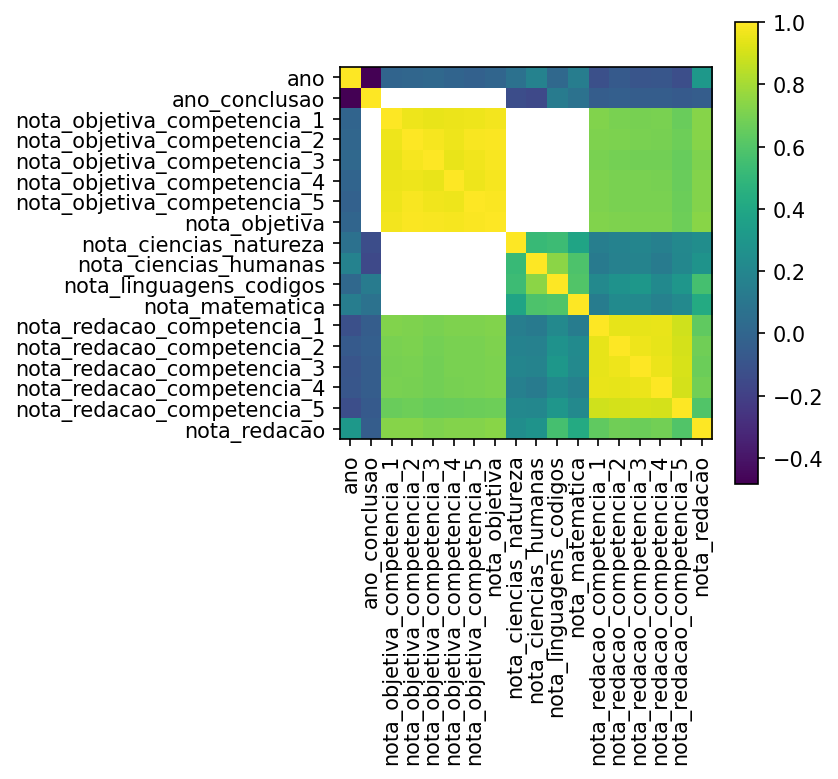

In [23]:
correlation = df_enem.select_dtypes(include='number').corr()

plt.figure(figsize = (4, 4), dpi = 150)
plt.xticks(range(18), labels = correlation.columns,rotation=90)
plt.yticks(range(18), labels = correlation.columns)
plt.imshow(correlation)
plt.colorbar()
plt.show()